In [1]:
%matplotlib inline
import obspy
import numpy as np
import math
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
client = Client("IRIS")
client2 = Client("SCEDC")
#client3 = Client("NCEDC")
import matplotlib

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec

import hvsrpy
import sigpropy

import pandas as pd

In [2]:
t = UTCDateTime("2020-09-19T06:38:46.930") 

In [3]:
chk = client.get_events(maxmagnitude=7.5,minmagnitude=4,endtime=t+1800,starttime=t-150000)
chk

38 Event(s) in Catalog:
2020-09-19T06:38:46.930000Z | +34.038, -118.080 | 4.54 Mw
2020-09-19T06:03:04.162000Z | +14.777,  -92.516 | 4.4  mb
...
2020-09-17T16:01:15.148000Z |  -2.371, +139.836 | 4.9  mb
2020-09-17T15:40:51.040000Z | -22.194, +170.281 | 4.8  mb
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [4]:
dtbf = 3000
dtaft = 3000

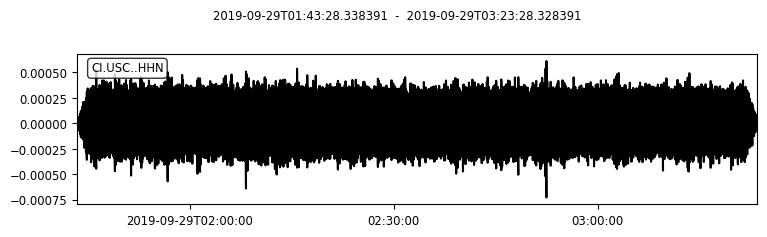

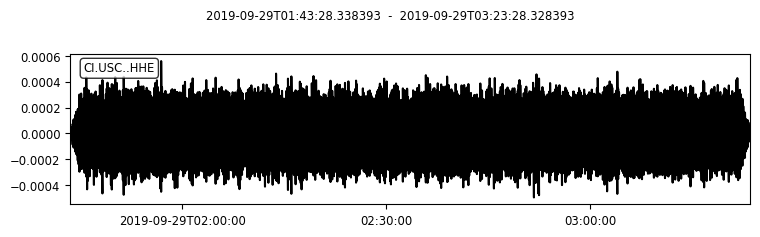

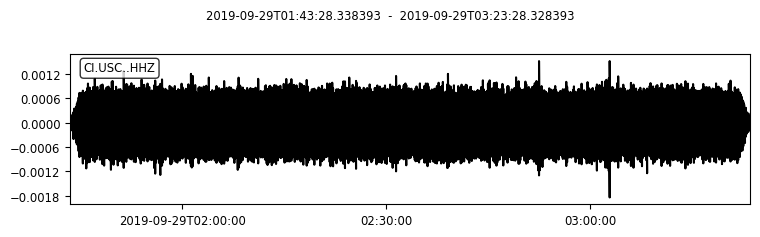

In [6]:
plt.rcParams['font.size'] = '10'
#2019-07-03T03:19:00.000
t = UTCDateTime("2019-09-29T02:33:28.330")  # Ridgcrest M7.1
t2 = UTCDateTime("2019-07-03T17:33:00.000") # Ridgcrest M6.4
[network, station, location, channel, sbef, saft] = ["CI", "USC", "*", "HHN", dtbf, dtaft]
[network, station, location, channel2, sbef, saft] = ["CI", "USC", "*", "HHE", dtbf, dtaft]
[network, station, location, channel3, sbef, saft] = ["CI", "USC", "*", "HHZ", dtbf, dtaft]
st_SLA = client.get_waveforms(network, station, location, channel, t - sbef, t + saft, attach_response = True)
st_SLA2 = client.get_waveforms(network, station, location, channel2, t - sbef, t + saft, attach_response = True)
st_SLA5 = client.get_waveforms(network, station, location, channel3, t - sbef, t + saft, attach_response = True)

st_SLA.remove_response(output='ACC')
st_SLA2.remove_response(output='ACC')

st_SLA5.remove_response(output='ACC')
st_SLA.plot()
st_SLA2.plot()

st_SLA5.plot()

plt.show()

In [7]:
ns = sigpropy.TimeSeries(st_SLA.traces[0].data, st_SLA.traces[0].stats.delta)
ew = sigpropy.TimeSeries(st_SLA2.traces[0].data, st_SLA2.traces[0].stats.delta)
vt = sigpropy.TimeSeries(st_SLA5.traces[0].data, st_SLA5.traces[0].stats.delta)

In [8]:
st_SLA.traces[0].data

array([-1.79787405e-08, -3.01718852e-08,  2.04547390e-08, ...,
       -1.06392555e-09, -2.22410819e-08, -3.00313953e-08])

In [9]:
st_SLA.traces[0].stats.delta

0.01

In [10]:
SLASensor = hvsrpy.Sensor3c(ns,ew,vt)

In [11]:
# Window length in seconds. In general low frequency peaks require longer window lengths.
# See the SESAME guidelines for specific window length recommendations.
windowlength = 600 #changed from 60

# Boolean to control whether Butterworth filter is applied. 
# Geopsy does not apply a bandpass filter.
filter_bool = False
# Low-cut frequency for bandpass filter.
filter_flow = 0.1                   
# High-cut frequency for bandpass filter.
filter_fhigh = 50                   
# Filter order.
filter_order = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1

In [12]:
# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 30 #changed from 40

# Minimum frequency after resampling
resample_fmin = 0.3
# Maximum frequency after resampling
resample_fmax = 20
# Number of frequencies after resampling
resample_fnum = 45
# Type of resampling {'log', 'linear'}
resample_type = 'log'

# Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
peak_f_lower = None
peak_f_upper = None

In [13]:
# Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
# Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
method = "geometric-mean"
# If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
azimuth = 0

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
max_iterations = 50

# Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
distribution_f0 = "lognormal"
# Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
distribution_mc = "lognormal"

In [14]:
# Manually set the ylimits of the HVSR figures. Default is None so limits will be set automatically.
ymin, ymax = 0, 10

In [15]:
bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}
resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}

In [16]:
hv = SLASensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)


Statistics before rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",1.05,0.13
"Fundamental Site Period, T0",0.95,0.13



Analysis summary:


,
Window length,600s
No. of windows,9
Number of iterations to convergence,2 of 50 allowed
No. of rejected windows,1



Statistics after rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",1.01,0.08
"Fundamental Site Period, T0",0.99,0.08


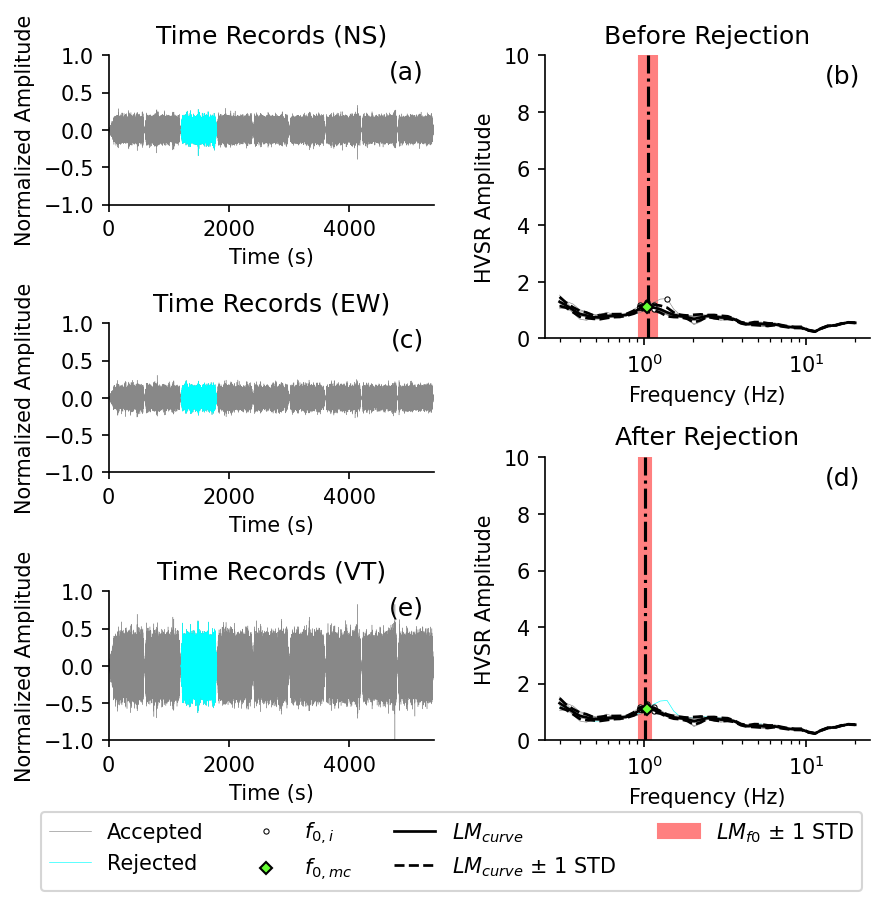

In [17]:
fig = plt.figure(figsize=(6,6), dpi=150)
gs = fig.add_gridspec(nrows=6,ncols=6)

ax0 = fig.add_subplot(gs[0:2, 0:3])
ax1 = fig.add_subplot(gs[2:4, 0:3])
ax2 = fig.add_subplot(gs[4:6, 0:3])

if rejection_bool:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = fig.add_subplot(gs[3:6, 3:6])
else:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = False


individual_width = 0.3
median_width = 1.3
for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
    # Rejected Windows
    if title=="After Rejection":
        if len(hv.rejected_window_indices):
            label = "Rejected"
            for amp in hv.amp[hv.rejected_window_indices]:
                ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                label=None
            
    # Accepted Windows
    label="Accepted"
    for amp in hv.amp[hv.valid_window_indices]:
        ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                label = label if title=="Before Rejection" else "")
        label=None
    
    # Window Peaks
    ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
            marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
            label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")
    
    # Peak Mean Curve
    ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
            marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
            label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")
    
    # Mean Curve
    label = r"$LM_{curve}$" if distribution_mc=="lognormal" else "Mean"   
    ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
            label="" if title=="Before Rejection" and rejection_bool else label)
    
    # Mean +/- Curve
    label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="lognormal" else "Mean ± 1 STD"
    ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3,
            label = "" if title=="Before Rejection" and rejection_bool else label)
    ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3)

    # f0 +/- STD
    if ymin is not None and ymax is not None:
        ax.set_ylim((ymin, ymax))
    label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="lognormal" else "Mean f0 ± 1 STD"    
    _ymin, _ymax = ax.get_ylim()
    ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [_ymin, _ymax], linestyle="-.", color="#000000")
    ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [_ymin, _ymax, _ymax, _ymin], 
            color = "#ff8080",
            label="" if title=="Before Rejection" and rejection_bool else label)
    ax.set_ylim((_ymin, _ymax))
    
    ax.set_xscale('log')
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("HVSR Amplitude")
    if rejection_bool:
        if title=="Before Rejection":
            print("\nStatistics before rejection:")
            hv.print_stats(distribution_f0)
            c_iter = hv.reject_windows(n, max_iterations=max_iterations, 
                                       distribution_f0=distribution_f0, distribution_mc=distribution_mc)
        elif title=="After Rejection":
            fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

            print("\nAnalysis summary:")  
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                    data=[f"{windowlength}s", str(SLASensor.ns.nseries), f"{c_iter} of {max_iterations} allowed", str(sum(hv.rejected_window_indices))]))            
            print("\nStatistics after rejection:")
            hv.print_stats(distribution_f0)
    else:
        display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                         data=[f"{windowlength}s", str(SLASensor.ns.nseries)]))
        hv.print_stats(distribution_f0)
        fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
        break
    ax.set_title(title)

norm_factor = SLASensor.normalization_factor
for ax, timerecord, name in zip([ax0,ax1,ax2], [SLASensor.ns, SLASensor.ew, SLASensor.vt], ["NS", "EW", "VT"]):
    ctime = timerecord.time
    amp = timerecord.amp/norm_factor
    ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
    ax.set_title(f"Time Records ({name})")
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlim(0, windowlength*timerecord.nseries)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Amplitude')
    ax.plot(ctime[hv.rejected_window_indices].T, amp[hv.rejected_window_indices].T, linewidth=0.2, color="cyan")

if rejection_bool:
    axs = [ax0, ax3, ax1, ax4, ax2]
else:
    axs = [ax0, ax3, ax1, ax2]
    
for ax, letter in zip(axs, list("abcde")):    
    ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)


fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
plt.show()

In [313]:
hv.mc_peak_frq()


1.16006332440824

In [8]:
hv.mc_peak_amp()


NameError: name 'hv' is not defined

In [9]:
hv.peak_frq


NameError: name 'hv' is not defined

In [10]:
st_SLA.traces[0].stats

NameError: name 'st_SLA' is not defined

In [23]:
35.89095, -117.28332, 2.904383931825406 #lat, long and amp of HVSR SLA, creating array for krig
35.69235, -117.75051, 3.974723902200456 #SRT
35.47954, -117.68212, 2.3314646157228966 #LRL

(35.47954, -117.68212, 2.3314646157228966)

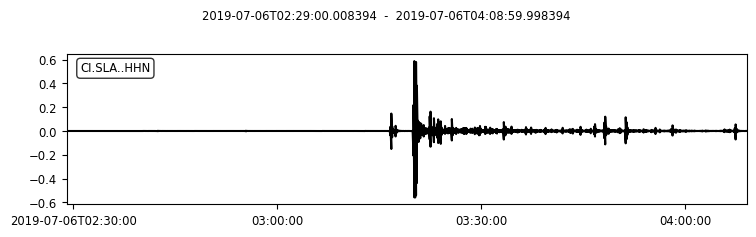

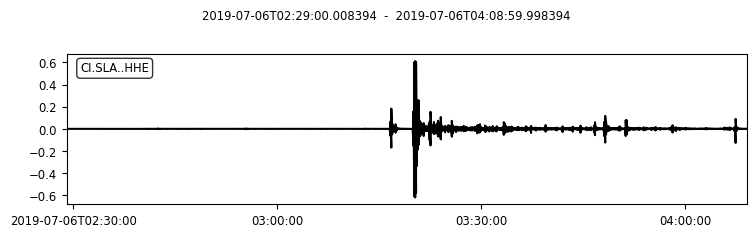

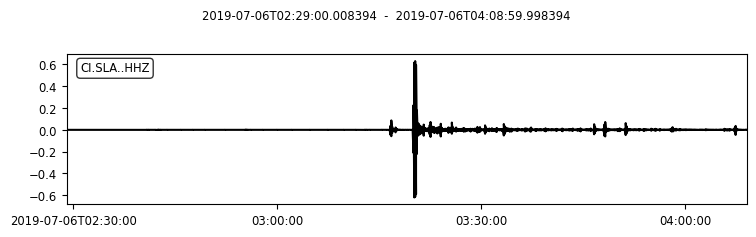

In [24]:
plt.rcParams['font.size'] = '10'

t = UTCDateTime("2019-07-06T03:19:00.000")  # Ridgcrest M7.1
t2 = UTCDateTime("2019-07-04T17:33:00.000") # Ridgcrest M6.4
[network, station, location, channel, sbef, saft] = ["CI", "SLA", "*", "HHN", dtbf, dtaft]
[network, station, location, channel2, sbef, saft] = ["CI", "SLA", "*", "HHE", dtbf, dtaft]
[network, station, location, channel3, sbef, saft] = ["CI", "SLA", "*", "HHZ", dtbf, dtaft]
st_SLA = client.get_waveforms(network, station, location, channel, t - sbef, t + saft, attach_response = True)
st_SLA2 = client.get_waveforms(network, station, location, channel2, t - sbef, t + saft, attach_response = True)
st_SLA5 = client.get_waveforms(network, station, location, channel3, t - sbef, t + saft, attach_response = True)

st_SLA.remove_response(output='ACC')
st_SLA2.remove_response(output='ACC')

st_SLA5.remove_response(output='ACC')
st_SLA.plot()
st_SLA2.plot()

st_SLA5.plot()

plt.show()

In [25]:
st_SLA.append(st_SLA2.traces[0])

2 Trace(s) in Stream:
CI.SLA..HHN | 2019-07-06T02:29:00.008394Z - 2019-07-06T04:08:59.998394Z | 100.0 Hz, 600000 samples
CI.SLA..HHE | 2019-07-06T02:29:00.008394Z - 2019-07-06T04:08:59.998394Z | 100.0 Hz, 600000 samples

In [26]:
st_SLA.append(st_SLA5.traces[0])

3 Trace(s) in Stream:
CI.SLA..HHN | 2019-07-06T02:29:00.008394Z - 2019-07-06T04:08:59.998394Z | 100.0 Hz, 600000 samples
CI.SLA..HHE | 2019-07-06T02:29:00.008394Z - 2019-07-06T04:08:59.998394Z | 100.0 Hz, 600000 samples
CI.SLA..HHZ | 2019-07-06T02:29:00.008394Z - 2019-07-06T04:08:59.998394Z | 100.0 Hz, 600000 samples

In [27]:
st_SLA.write('SLA_7point1.mseed', format='MSEED') 

C:\Users\aquia\anaconda3\lib\site-packages\obspy\io\mseed\core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [28]:
sensor = hvsrpy.Sensor3c.from_mseed("SLA_7point1.mseed")


Statistics before rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",1.21,0.91
"Fundamental Site Period, T0",0.83,0.91



Analysis summary:


,
Window length,200s
No. of windows,29
Number of iterations to convergence,7 of 50 allowed
No. of rejected windows,13



Statistics after rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",2.03,0.06
"Fundamental Site Period, T0",0.49,0.06


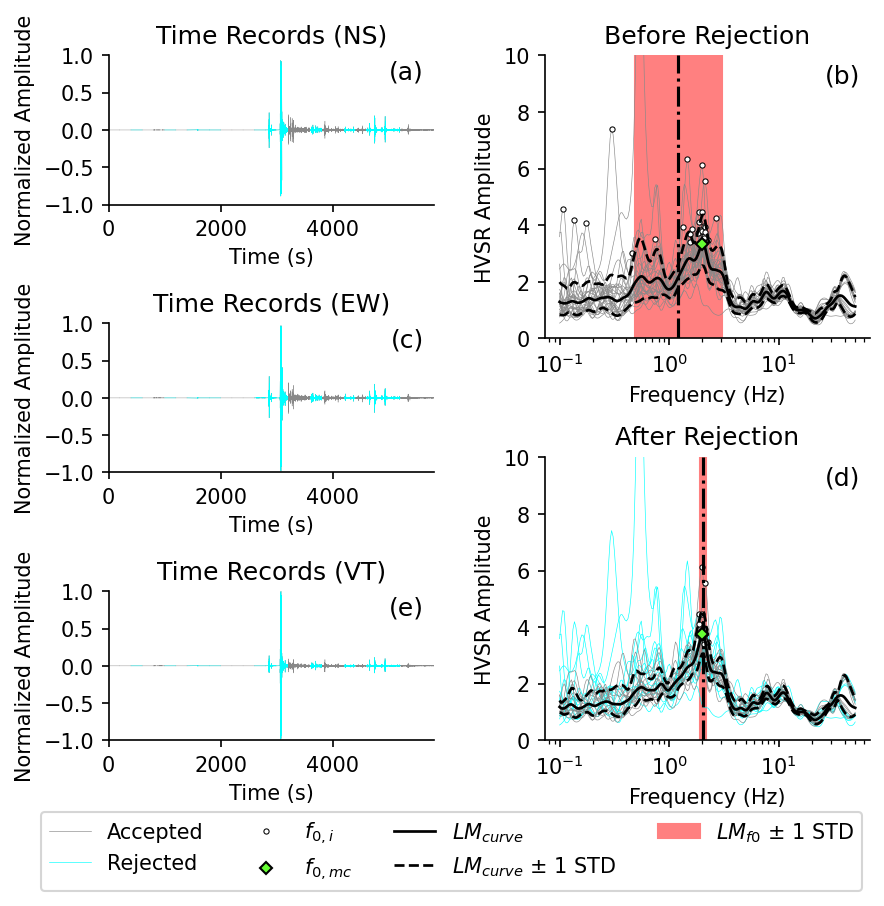

In [29]:
fig = plt.figure(figsize=(6,6), dpi=150)
gs = fig.add_gridspec(nrows=6,ncols=6)

ax0 = fig.add_subplot(gs[0:2, 0:3])
ax1 = fig.add_subplot(gs[2:4, 0:3])
ax2 = fig.add_subplot(gs[4:6, 0:3])

if rejection_bool:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = fig.add_subplot(gs[3:6, 3:6])
else:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = False

file_name = "SLA_7point1.mseed"
sensor = hvsrpy.Sensor3c.from_mseed(file_name)
bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}
resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)



individual_width = 0.3
median_width = 1.3
for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
    # Rejected Windows
    if title=="After Rejection":
        if len(hv.rejected_window_indices):
            label = "Rejected"
            for amp in hv.amp[hv.rejected_window_indices]:
                ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                label=None
            
    # Accepted Windows
    label="Accepted"
    for amp in hv.amp[hv.valid_window_indices]:
        ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                label = label if title=="Before Rejection" else "")
        label=None
    
    # Window Peaks
    ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
            marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
            label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")
    
    # Peak Mean Curve
    ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
            marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
            label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")
    
    # Mean Curve
    label = r"$LM_{curve}$" if distribution_mc=="lognormal" else "Mean"   
    ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
            label="" if title=="Before Rejection" and rejection_bool else label)
    
    # Mean +/- Curve
    label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="lognormal" else "Mean ± 1 STD"
    ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3,
            label = "" if title=="Before Rejection" and rejection_bool else label)
    ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3)

    # f0 +/- STD
    if ymin is not None and ymax is not None:
        ax.set_ylim((ymin, ymax))
    label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="lognormal" else "Mean f0 ± 1 STD"    
    _ymin, _ymax = ax.get_ylim()
    ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [_ymin, _ymax], linestyle="-.", color="#000000")
    ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [_ymin, _ymax, _ymax, _ymin], 
            color = "#ff8080",
            label="" if title=="Before Rejection" and rejection_bool else label)
    ax.set_ylim((_ymin, _ymax))
    
    ax.set_xscale('log')
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("HVSR Amplitude")
    if rejection_bool:
        if title=="Before Rejection":
            print("\nStatistics before rejection:")
            hv.print_stats(distribution_f0)
            c_iter = hv.reject_windows(n, max_iterations=max_iterations, 
                                       distribution_f0=distribution_f0, distribution_mc=distribution_mc)
        elif title=="After Rejection":
            fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

            print("\nAnalysis summary:")  
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                    data=[f"{windowlength}s", str(sensor.ns.nseries), f"{c_iter} of {max_iterations} allowed", str(sum(hv.rejected_window_indices))]))            
            print("\nStatistics after rejection:")
            hv.print_stats(distribution_f0)
    else:
        display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                         data=[f"{windowlength}s", str(sensor.ns.nseries)]))
        hv.print_stats(distribution_f0)
        fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
        break
    ax.set_title(title)

norm_factor = sensor.normalization_factor
for ax, timerecord, name in zip([ax0,ax1,ax2], [sensor.ns, sensor.ew, sensor.vt], ["NS", "EW", "VT"]):
    ctime = timerecord.time
    amp = timerecord.amp/norm_factor
    ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
    ax.set_title(f"Time Records ({name})")
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlim(0, windowlength*timerecord.nseries)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Amplitude')
    ax.plot(ctime[hv.rejected_window_indices].T, amp[hv.rejected_window_indices].T, linewidth=0.2, color="cyan")

if rejection_bool:
    axs = [ax0, ax3, ax1, ax4, ax2]
else:
    axs = [ax0, ax3, ax1, ax2]
    
for ax, letter in zip(axs, list("abcde")):    
    ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)


fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
plt.show()